In [1]:
from coin import COIN

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Test Modules
## Test COIN

In [11]:
# Test COIN_Python
retention_values = np.linspace(0.8, 1, 500, endpoint=True)
drift_values = np.linspace(-0.1, 0.1, 500, endpoint=True)
state_values = np.linspace(-1.5, 1.5, 500, endpoint=True)
bias_values = np.linspace(-1.5, 1.5, 500, endpoint=True)
state_feedback_values = np.linspace(-1.5, 1.5, 500, endpoint=True)

# store = [
#     "state_feedback", "motor_output", "responsibilities", "predicted_probabilities","inds_resampled","context"
# ]

coin_model = COIN(
    retention_values=retention_values,
    drift_values=drift_values, 
    bias_values=bias_values, 
    state_feedback_values=state_feedback_values, 
)

# coin_model.perturbations = np.concatenate([
#     np.ones((50, )),
# ])

coin_model.perturbations = np.concatenate([
    np.zeros((50, )), 
    np.ones((125, )), 
    -np.ones((15, )), 
    np.ones((150, )) * np.nan, 
])

output = coin_model.simulate_coin()

# Helper method to get context relabelled responsibilities
#known_resp, novel_resp = coin_model.get_responsibilities(output)

pred_resp = coin_model.get_predicted_responsibilities(output, state_values)

# p_c = coin_model.get_predicted_probabilities(output)

# plt.figure(figsize=(8, 5))
# plt.plot(output["runs"][0]["state_feedback"], "b.", label="state feedback")
# plt.plot(output["runs"][0]["motor_output"], "r", label="motor output")
# plt.legend()
# #plt.axhline(0)

# plt.figure(figsize=(8, 5))
# plt.plot(known_resp)

# plt.figure(figsize=(8, 5))
# plt.plot(novel_resp)

Simulating the COIN model
Finding optimal context labels (trial = 50)
Finding optimal context labels (trial = 100)
Finding optimal context labels (trial = 150)
Finding optimal context labels (trial = 200)
Finding optimal context labels (trial = 250)
Finding optimal context labels (trial = 300)
Permuting context labels (trial = 50)
Permuting context labels (trial = 100)
Permuting context labels (trial = 150)
Permuting context labels (trial = 200)
Permuting context labels (trial = 250)
Permuting context labels (trial = 300)


In [ ]:
from itertools import permutations
from scipy.optimize import linear_sum_assignment

def _best_perm(s, typical, *, K, have_scipy=True):
    """
    Find the permutation π that minimises the Hamming distance between a
    particle sequence `s` and the reference sequence `typical`, given that
    *both* sequences contain exactly `K` distinct labels (but the numeric
    values need not coincide).

    Returns
    -------
    π : ndarray, shape (K,)
        π[j] is *the original label value* that should be mapped to the
        reference label that occupies column j in the contingency table.
        (Same contract as the original code.)
    """
    # ------------------------------------------------------------------
    # 1. Compress the two value sets to 0 … K‑1
    # ------------------------------------------------------------------
    rows = np.unique(s)          # the K distinct labels used by this particle
    cols = np.unique(typical)    # the K distinct labels in the reference

    # Safety check: if something slipped through the mode filter, bail early
    if rows.size != K or cols.size != K:
        raise ValueError("Sequences do not share the modal number of contexts")

    # Build look‑up tables value → compact index (vectorised via np.searchsorted)
    row_idx = np.searchsorted(rows, s)         # shape (T,)
    col_idx = np.searchsorted(cols, typical)   # shape (T,)

    # ------------------------------------------------------------------
    # 2. Contingency matrix in the compact K×K space
    # ------------------------------------------------------------------
    cont = np.zeros((K, K), dtype=int)
    np.add.at(cont, (row_idx, col_idx), 1)

    # ------------------------------------------------------------------
    # 3. Solve the assignment   (maximise the agreement counts)
    # ------------------------------------------------------------------
    if K > 8:
        r, c = linear_sum_assignment(-cont)    # Hungarian on the negative counts
        # π[j] should be "which *original* label from `rows` goes to col j?"
        π = np.empty(K, dtype=rows.dtype)
        π[c] = rows[r]
    else:
        # brute force for small K (K! permutations)
        perms = np.array(list(permutations(np.arange(K))), dtype=int)  # (K!, K)
        matches = (cont[np.arange(K), perms.T]).sum(0)                 # (K!,)
        best = perms[matches.argmax()]
        π = rows[best]

    return π

def label_switching_correction(prob, *, return_all=False):
    """
    Resolve label‑switching across particles by aligning every particle to the
    'typical' (medoid) particle with the minimum average Hamming distance.

    Parameters
    ----------
    prob : ndarray, shape (C, P, T)
        Posterior probabilities P(C | particle, time).
    return_all : bool, default=False
        If True, also return the list of permutations and the index of the
        typical particle.

    Returns
    -------
    prob_aligned : ndarray, shape (C, P′, T)
        `prob` with *each* particle’s context axis permuted so that contexts
        are in the same register.  Only particles that share the modal number
        of contexts are kept (exactly as in the paper).
    perms : list[np.ndarray]            (optional, if `return_all`)
        πₚ such that
        `prob_aligned[:, p, :] == prob_orig[πₚ, p, :]`.
    typical_idx : int                  (optional, if `return_all`)
        Index (w.r.t. the retained particles) of the 'typical' sequence.
    """

    C, P, T = prob.shape

    # ------------------------------------------------------------------
    # 1. Hard context sequence for every particle at every time point
    # ------------------------------------------------------------------
    seq = prob.argmax(0)             # shape (P, T) — integer labels ∈ [0, C)

    # ------------------------------------------------------------------
    # 2. Keep only particles whose *number* of distinct contexts equals the
    #    posterior mode (the “most common number of contexts” in the paper).
    # ------------------------------------------------------------------
    ctx_counts = np.array([np.unique(seq[p]).size for p in range(P)])
    mode_ctx = np.bincount(ctx_counts).argmax()
    keep_mask = ctx_counts == mode_ctx
    seq = seq[keep_mask]             # (P′, T)
    prob = prob[:, keep_mask]        # (C, P′, T)
    P = seq.shape[0]
    K = mode_ctx                     # number of contexts after restriction

    # ------------------------------------------------------------------
    # 3. Choose the 'typical' particle:
    #    the one with the minimum *average* Hamming distance to all others.
    # ------------------------------------------------------------------
    # Broadcasting gives every pairwise Boolean mismatch matrix (P,P,T)
    mism = seq[:, None, :] != seq[None, :, :]
    hamm = mism.sum(-1)              # pairwise Hamming counts  (P,P)
    typical_idx = hamm.sum(1).argmin()
    typical = seq[typical_idx]       # reference sequence (length T)

    # Identity for contexts that never appear (only matters if K < C)
    id_tail = np.arange(K, C)

    perm_list, prob_aligned = [], np.empty_like(prob)

    for p in range(P):
        π = _best_perm(seq[p], typical, K=K)
        # Build length‑C permutation: first the optimised part, then identity
        full_perm = np.concatenate((π, id_tail))
        perm_list.append(full_perm)
        prob_aligned[:, p] = prob[full_perm, p]

    if return_all:
        return prob_aligned, perm_list, typical_idx

    return prob_aligned

aligned = label_switching_correction(resp)

## Test Gymnasium and RL
### Q-Learning

Training and Visualising

In [ ]:
from environments import CustomMountainCarEnv
from rl import QLearningAgent
import matplotlib.pyplot as plt

# 1. Create the MountainCar environment
env = CustomMountainCarEnv(amplitude=1.0, force_sf=1.0, render_mode="none")

# 2. Create the Q-learning agent
agent = QLearningAgent(
    env=env,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.95,
    epsilon=1,
    epsilon_decay=0.999,
    min_epsilon=0.01
)

# 3. Train the agent
q_table, training_rewards = agent.train(
    env=env,
    n_episodes=5000,
    max_steps_per_episode=200,
    verbose=True,
    print_freq=200
)

# 4. Plot the rewards
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-learning Rewards - Training")
plt.show()


Visualisation

In [ ]:
# Evaluate the agent and visualise
env = CustomMountainCarEnv(amplitude=1.0, force_sf=1.0, render_mode="human")

evaluation_rewards = agent.evaluate(
    env=env,
    n_episodes=1,
    max_steps_per_episode=200
)

print(f"Evaluation reward: {evaluation_rewards}")


### COIN Q-Learning
Training

In [ ]:
# Importing and setting up contextual estimates
from coin import COIN

# True scale factors
scale_factors = np.concatenate([
    0.0*np.ones((500, )), 
    1.0*np.ones((500, )),
    1.4*np.ones((500, )),
    0.0*np.ones((500, )),
    0.5*np.ones((500, ))
    ])

coin_model = COIN(
    prior_precision_drift=1,
    store=store
) # use default parameters for now
coin_model.perturbations = scale_factors

output = coin_model.simulate_coin()

resp = output["runs"][0]["responsibilities"]
p_context = np.sum(resp, axis=1)
p_context = p_context / np.sum(p_context, axis=0, keepdims=True)

state_feedback = output["runs"][0]["state_feedback"]
plt.scatter(
    np.arange(len(state_feedback)), 
    state_feedback
)
plt.show()


In [ ]:
# Plot contextual probabilities
plt.plot(p_context.T)
plt.show()

#### COIN Q-Learning

In [ ]:
from environments import CustomMountainCarEnv
from rl import COINQLearningAgent
import numpy as np
import copy
%load_ext autoreload
%autoreload 2

# Set p contexts and scale factors for testing - DISABLE IF USING COIN
scale_factors = np.concatenate([
    0.0*np.ones((1, )), 
    1.0*np.ones((1, )),
    0.0*np.ones((1,))
])
p_context = np.zeros((scale_factors.shape[0], 3))
p_context[scale_factors == 0.0, 0] = 1.0
p_context[scale_factors == 1.0, 1] = 1.0

# Begin training loop
num_episodes = p_context.shape[0]
C = p_context.shape[1]-1

env = CustomMountainCarEnv(amplitude=1.0, force_sf=1.0, render_mode="none")
# Create the COIN Q-learning agent
agent = COINQLearningAgent(
    env=env,
    max_contexts=C,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.999
)

rewards = []

for i in range(0,num_episodes):
    # Create the MountainCar environment with the true amplitude
    env = CustomMountainCarEnv(amplitude=scale_factors[i], render_mode="none")

    # Train the agent in the current context
    # Reset random seed
    if i == 0:
        np.random.seed(0)
    elif i == 2:
        agent_temp = copy.deepcopy(agent)
        np.random.seed(1)
    training_reward = agent.train_step(
        env=env,
        p_context=p_context[i,:],
        max_steps_per_episode=1000,
    )

    rewards.append(training_reward)

    # Print the average training reward every 500 episodes
    if ((i+1)%5000 == 0):
        print(f"Episode {i+1}, Training reward: {np.mean(rewards[-500:])}")
        print(f"Epsilons: {agent.epsdat}")
        print(f"P contexts: {p_context[i,:]}")

In [ ]:
import matplotlib.pyplot as plt

# Smooth twice
idx = scale_factors == 0.0
rewards_c = np.array(rewards)[idx]
rewards_s = np.convolve(rewards_c, np.ones(50)/50, mode='valid')

plt.plot(rewards_s)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.show()

In [ ]:
from environments import CustomMountainCarEnv
from rl import COINQLearningAgent
import numpy as np
import copy

# Set p contexts and scale factors for testing - DISABLE IF USING COIN
scale_factors = np.concatenate([
    0.0*np.ones((2, )), 
])
p_context = np.zeros((scale_factors.shape[0], 2))
p_context[scale_factors == 0.0, 0] = 1.0

# Begin training loop
num_episodes = p_context.shape[0]
C = p_context.shape[1]-1

env = CustomMountainCarEnv(amplitude=1.0, force_sf=1.0, render_mode="none")
# Create the COIN Q-learning agent
agent2 = COINQLearningAgent(
    env=env,
    max_contexts=C,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.999
)

rewards = []

for i in range(0,num_episodes):
    # Create the MountainCar environment with the true amplitude
    env = CustomMountainCarEnv(amplitude=scale_factors[i], render_mode="none")

    # Train the agent in the current context
    if i == 1:
        agent2_temp = copy.deepcopy(agent2)
    np.random.seed(i)
    training_reward = agent2.train_step(
        env=env,
        p_context=p_context[i,:],
        max_steps_per_episode=1000,
    )
    rewards.append(training_reward)

    # Print the average training reward every 500 episodes
    if ((i+1)%5000 == 0):
        print(f"Episode {i+1}, Training reward: {np.mean(rewards[-500:])}")
        print(f"Epsilons: {agent2.epsdat}")

In [ ]:
print(Qagent_temp.Qdat[0]-Qagent2_temp.Qdat[0])

In [ ]:
import matplotlib.pyplot as plt

# Smooth twice
idx = scale_factors == 0.0
rewards_c = np.array(rewards)[idx]
rewards_s = np.convolve(rewards_c, np.ones(50)/50, mode='valid')

plt.plot(rewards_s)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.show()

In [ ]:
# Evaluate the agent and visualise
env = CustomMountainCarEnv(amplitude=1.00, force_sf=1.0, render_mode="human")
evaluation_rewards = agent.evaluate(
    env=env,
    p_context=p_context[:,1750],
    n_episodes=1,
    max_steps_per_episode=1000
)

Qdat = agent.Qdat.copy()

print(f"Evaluation reward: {evaluation_rewards}")

### PPO
Training and Importing

In [1]:
from rl import PPOAgent
import gymnasium as gym
from tqdm.notebook import tqdm

env = gym.make("CartPole-v1")
ppo = PPOAgent(obs_dim=4, act_dim=2)

# plain PPO training
for epoch in tqdm(range(10)):
    r = ppo.train_step(env)
    mean_return = r["mean_episode_return"]
    mean_reward = r["mean_reward_per_step"]
    value_loss = r["value_loss"]
    policy_loss = r["policy_loss"]
    if epoch % 1 == 0:
       print(f"epoch {epoch}: mean_return {mean_return:.2f}, mean_reward {mean_reward:.2f}, value_loss {value_loss:.2f}, policy_loss {policy_loss:.2f}")



  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\richa\Documents\PhD Projects\COINRL\rl.py:601: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adv = torch.tensor(adv, device=self.device)
c:\Users\richa\Documents\PhD Projects\COINRL\rl.py:602: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ret = torch.tensor(ret, device=self.device)


epoch 0: mean_return 18.26, mean_reward 1.00, value_loss 8.14, policy_loss -0.20
epoch 1: mean_return 24.20, mean_reward 1.00, value_loss 29.02, policy_loss 0.05
epoch 2: mean_return 34.10, mean_reward 1.00, value_loss 54.77, policy_loss -0.03
epoch 3: mean_return 48.71, mean_reward 1.00, value_loss 85.53, policy_loss 0.29
epoch 4: mean_return 91.09, mean_reward 1.00, value_loss 51.43, policy_loss -0.08
epoch 5: mean_return 112.00, mean_reward 1.00, value_loss 57.77, policy_loss -0.15
epoch 6: mean_return 133.00, mean_reward 1.00, value_loss 95.26, policy_loss 0.12
epoch 7: mean_return 167.50, mean_reward 1.00, value_loss 112.39, policy_loss 0.33
epoch 8: mean_return 203.00, mean_reward 1.00, value_loss 47.25, policy_loss -0.12
epoch 9: mean_return 303.00, mean_reward 1.00, value_loss 41.94, policy_loss 0.07


Visualising

In [ ]:
# Visualise training
from environments import CustomCartPoleEnv
env = CustomCartPoleEnv(render_mode="human", length=2)
ppo.evaluate(env, n_episodes=3)


### COIN PPO

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Simulating the COIN model


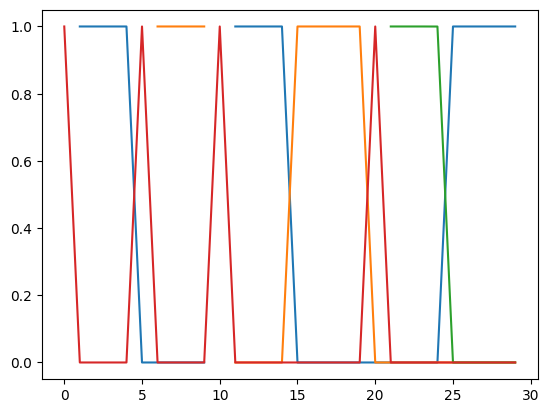

In [8]:
# First, set up all episodes data - note that all the episodes are observed sequentially during training
# with each epoch observing the next sequence, depending on the training
import numpy as np
from coin import COIN
from environments import CustomCartPoleEnv
from rl import COINPPOAgent
import gymnasium as gym
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# lock seed
np.random.seed(0)

# "data" represents the length of the rod in the CartPole environment
data = np.concatenate([
    0.5*np.ones((5, )),
    1.0*np.ones((5, )),
    1.5*np.ones((5, )),
    0.5*np.ones((5, )),
    0.3*np.ones((5, )),
    1.5*np.ones((5, ))
])

# Run the COIN model for contextual estimates
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

coin_model.perturbations = data

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1)

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1)

import matplotlib.pyplot as plt

# Plot contextual probabilities
plt.plot(p_contexts)

In [ ]:
# Create test data
p_contexts = np.nan*np.zeros(p_contexts.shape)
p_contexts[15:30, 0] = 1.0
p_contexts[0:15,-1] = 1.0
p_contexts[15:, -1] = 0.0

data = np.concatenate([
    0.5*np.ones((15, )), 
    0.5*np.ones((15, )), 
])

# p_contexts = np.nan*np.zeros(p_contexts.shape)
# p_contexts[:, 0] = 1.0
# p_contexts[:, -1] = 0.0

# data = 0.5*np.ones((30,))

plt.figure(figsize=(8, 5))
plt.plot(data)

plt.figure(figsize=(8, 5))
plt.plot(p_contexts)

In [ ]:
from tqdm.notebook import tqdm

# Write data to context-prob dictionary form
data_dict = {}
J = p_contexts.shape[1]-1 # number of contexts (excluding novel)
for i in range(len(data)):
    data_dict[i] = {}
    for j in range(J):
        data_dict[i][j+1] = p_contexts[i,j]
    data_dict[i]['novel'] = p_contexts[i,-1]

env = CustomCartPoleEnv(render_mode="none", length=2)
ppo = COINPPOAgent(base_obs_dim=4, act_dim=2, ctx_ids=data_dict[0].keys())

mean_returns = []

# COIN PPO training - Each epoch goes through 50 steps (same context)
for epoch in tqdm(range(len(data))):
    # Set length for current epoch
    env.length = data[epoch]

    # Set current context function
    context_fcn = lambda i: data_dict[epoch]

    r = ppo.train_step(env, context_probs_fn=context_fcn) # Rollout steps here allows for a minimum of 5 episodes per epoch
    mean_return = r["mean_episode_return"]
    mean_reward = r["mean_reward_per_step"]
    value_loss = r["value_loss"]
    policy_loss = r["policy_loss"]
    mean_returns.append(mean_return)
    if epoch % 5 == 0:
       print(f"epoch {epoch}: mean_return {mean_return:.2f}, mean_reward {mean_reward:.2f}, value_loss {value_loss:.2f}, policy_loss {policy_loss:.2f}")


In [ ]:
# Plot mean returns
plt.figure(figsize=(8,10))
plt.scatter(np.arange(len(mean_returns)),mean_returns)

# Test on the cartpole
env = CustomCartPoleEnv(render_mode="human", length=0.5)
ppo.evaluate(env, n_episodes=3, context_probs_fn=lambda i: data_dict[23]) # Set context function to the first episode (length 1.0)